# Idealized Case 2: Two crossing Blobs

This tutorial shows the most important steps of tracking with `tobac` using an idealized case:

1. [Data Creation](#1.-Data-Creation)

## Data Creation

In [77]:
import tobac
import numpy as np
import matplotlib.pyplot as plt
import datetime
import xarray as xr
import seaborn as sns

sns.set_context("talk")

In [78]:
x_min, y_min, x_max, y_max, = 0, 0, 10, 10
t_min, t_max = 0, 10

x = np.linspace(x_min, x_max, 100)
y = np.linspace(y_min, y_max, 100)
t = np.linspace(t_min, t_max, 20)

tt, yy, xx = np.meshgrid(t, y, x, indexing='ij')

In [79]:
def create_wandering_blob(x_0, y_0, v_x, v_y, sigma=0.1, t_create=t_min, t_vanish=t_max):

    exponent = (xx - x_0 - v_x*(tt-t_create))**2 + (yy - y_0 - v_y*(tt-t_create))**2
    feature_alive = np.logical_and(tt>=t_create , tt<=t_vanish)
    blob = np.where(feature_alive, np.exp(-exponent/sigma), 0)
    
    return blob

def create_xarray(array):

    t_0 = np.datetime64('2022-04-01T00:00')
    t_delta = np.timedelta64(1, 'm')
    time = np.array([t_0 + i*t_delta for i in range(len(array))])
    
    coords = {'time':time,
             'projection_x_coordinate':x,
             'projection_y_coordinate':y
             }
    
    attributes = {'units': ('m s-1')}
    
    data = xr.DataArray(data=array, 
                        coords=coords,  
                        attrs=attributes)
    return data

In [80]:
blob_1 = create_wandering_blob(0, 0, 1, 1)
blob_2 = create_wandering_blob(10, 0, -1, 1)
blob_mask = blob_1 > blob_2
blob = np.where(blob_mask, blob_1, blob_2)

data = create_xarray(blob)

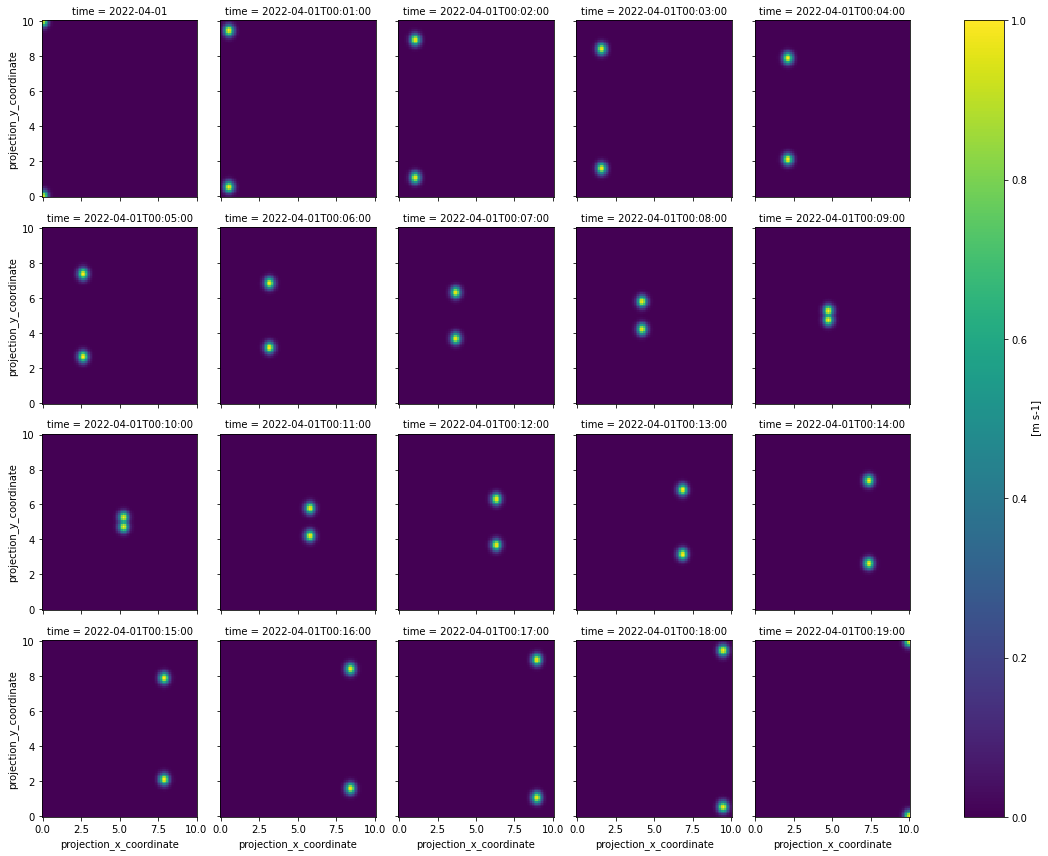

In [102]:
%matplotlib inline
data.plot(cmap = 'viridis', 
          col='time', 
          col_wrap=5, 
          x = 'projection_x_coordinate', 
          y = 'projection_y_coordinate')

## Influence of Tracking Method

In [82]:
%%capture
dxy, dt = tobac.utils.get_spacings(data, grid_spacing = x_max/200)
features = tobac.themes.tobac_v1.feature_detection_multithreshold(data, dxy, threshold=0.9)

In [186]:
%matplotlib inline
d_max = 0.4

track_1 = tobac.themes.tobac_v1.linking_trackpy(features, 
                                              data, 
                                              dt, 
                                              dxy, 
                                              d_max=d_max,
                                              method_linking='random',
                                              subnetwork_size=2)

track_2 = tobac.themes.tobac_v1.linking_trackpy(features, 
                                              data, 
                                              dt, 
                                              dxy, 
                                              d_max=d_max, 
                                              method_linking='predict',
                                              subnetwork_size=2)

Frame 19: 2 trajectories present.


Text(0.5, 1.0, 'predict')

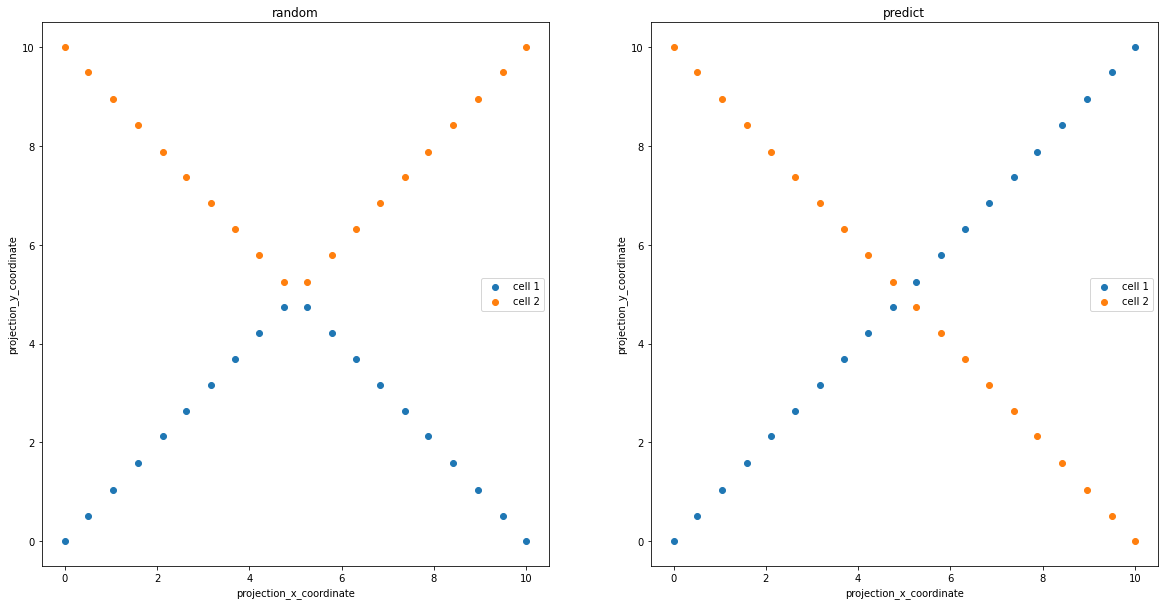

In [187]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (20, 10))

for i, cell_track in track_1.groupby("cell"):
    cell_track.plot.scatter(
        x="projection_x_coordinate",
        y="projection_y_coordinate",
        ax=ax1,
        marker="o",
        label="cell {0}".format(int(i)),
    )
ax1.legend()
ax1.set_title('random')

for i, cell_track in track_2.groupby("cell"):

    cell_track.plot.scatter(
        x="projection_x_coordinate",
        y="projection_y_coordinate",
        ax=ax2,
        marker="o",
        label="cell {0}".format(int(i)),
    )
ax2.legend()
ax2.set_title('predict')

## Algorithm

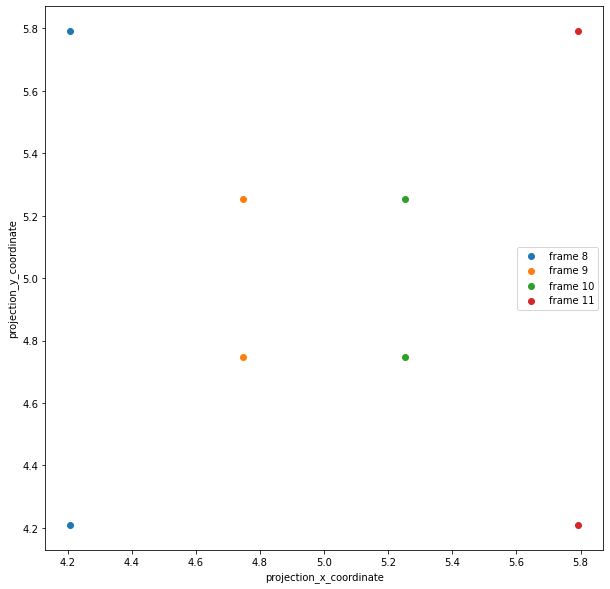

In [205]:
fig, ax = plt.subplots(figsize = (10, 10))

for frame in [8, 9, 10, 11]:

    features.where(features['frame']==frame).plot.scatter(
        x = 'projection_x_coordinate', 
        y = 'projection_y_coordinate',
        ax=ax,
        label ='frame {}'.format(frame)
    )
plt.legend()

### Search Radius 

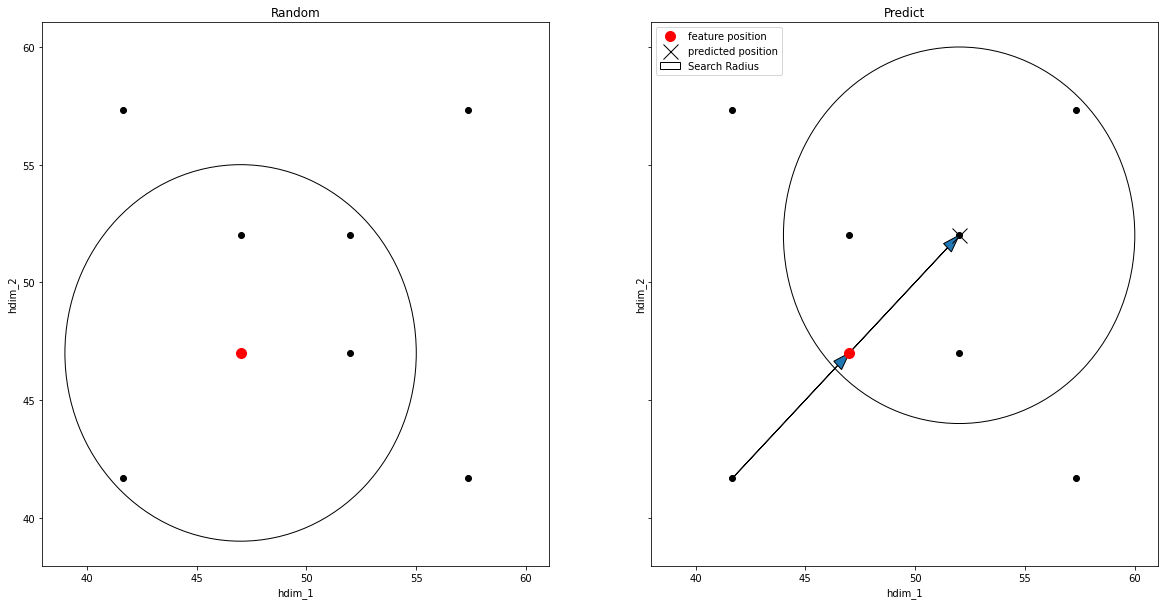

In [241]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 10), sharex=True, sharey=True)
radius = int(d_max / dxy)

for frame in [8, 9, 10, 11]:

    features.where(features['frame']==frame).plot.scatter(
        x = 'hdim_1', 
        y = 'hdim_2',
        color='black',
        ax=ax1)
    
    features.where(features['frame']==frame).plot.scatter(
        x = 'hdim_1', 
        y = 'hdim_2',
        color='black',
        ax=ax2)

position_0 = (features.where(features['frame']==8).dropna(dim='index')['hdim_1'][0],
            features.where(features['frame']==8).dropna(dim='index')['hdim_2'][0],
                )     

position_1 = (features.where(features['frame']==9).dropna(dim='index')['hdim_1'][0],
            features.where(features['frame']==9).dropna(dim='index')['hdim_2'][0],
                ) 
position_2 = (features.where(features['frame']==10).dropna(dim='index')['hdim_1'][1],
            features.where(features['frame']==10).dropna(dim='index')['hdim_2'][1],
                ) 

ax1.plot(position_1[0], position_1[1], marker = 'o', color = 'red', markersize = 10, linestyle='', label = 'feature position')
circle_1 = plt.Circle(position_1, radius, fill=False, label ='Search Radius')
ax1.add_patch(circle_1)
ax1.set_title('Random')

ax2.plot(position_1[0], position_1[1], marker = 'o', color = 'red', markersize = 10, linestyle='', label = 'feature position')
ax2.plot(position_2[0], position_2[1], marker = 'x', color = 'black', markersize = 15, linestyle='', label = 'predicted position')
circle_2 = plt.Circle(position_2, radius, fill=False, label ='Search Radius')
ax2.add_patch(circle_2)
ax2.arrow(position_0[0], position_0[1], position_1[0]-position_0[0], position_1[1]-position_0[1], head_width=0.5, length_includes_head=True)
ax2.arrow(position_1[0], position_1[1], position_2[0]-position_1[0], position_2[1]-position_1[1], head_width=0.5, length_includes_head=True)
ax2.set_title('Predict')
ax2.legend()

<IPython.core.display.Javascript object>


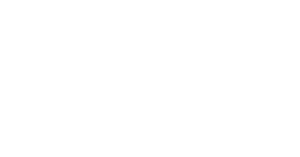

/home/nils/anaconda3/envs/tob_v2/lib/python3.7/site-packages/matplotlib/animation.py:890: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  'Animation was deleted without rendering anything. This is '


In [72]:
from matplotlib.animation import FuncAnimation
%matplotlib notebook
fig, ax = plt.subplots()

def animate(i):
    ax.imshow(data[i])
    
anim = FuncAnimation(fig, animate, frames = 20)

In [162]:
features.where(features['frame']==11).dropna(dim='index')['projection_x_coordinate'][0]

<xarray.DataArray 'projection_x_coordinate' ()>
array(5.79124579)
Coordinates:
    index    int64 22

In [152]:
features

<xarray.Dataset>
Dimensions:                  (index: 40)
Coordinates:
  * index                    (index) int64 0 1 2 3 4 5 6 ... 34 35 36 37 38 39
Data variables:
    frame                    (index) int64 0 0 1 1 2 2 3 ... 17 17 18 18 19 19
    idx                      (index) int64 1 2 1 2 1 2 1 2 1 ... 1 2 1 2 1 2 1 2
    hdim_1                   (index) float64 0.0 0.0 5.0 5.0 ... 94.0 99.0 99.0
    hdim_2                   (index) float64 0.0 99.0 5.0 94.0 ... 94.0 0.0 99.0
    num                      (index) int64 1 1 1 1 3 3 3 3 1 ... 3 3 3 3 1 1 1 1
    threshold_value          (index) float64 0.9 0.9 0.9 0.9 ... 0.9 0.9 0.9 0.9
    feature                  (index) int64 1 2 3 4 5 6 7 ... 35 36 37 38 39 40
    time                     (index) object 2022-04-01 00:00:00 ... 2022-04-0...
    timestr                  (index) object '2022-04-01 00:00:00' ... '2022-0...
    projection_x_coordinate  (index) float64 0.0 0.0 0.5051 ... 9.495 10.0 10.0
    projection_y_coordinate  (index) float64 0.0 10.0 0.5051 ... 9.495 0.0 10.0